## 0. Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, TFAlbertModel, TFElectraModel, TFDistilBertModel, DistilBertModel
from transformers import ElectraTokenizer, BertTokenizerFast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence

In [2]:
strategy = tf.distribute.get_strategy()

## 1. Load Dataset

In [3]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')
train_multinli = pd.read_csv('../dataset/kornli/multinli.train.ko.tsv', delimiter='\t', error_bad_lines=False)
train_snli = pd.read_csv('../dataset/kornli/snli_1.0_train.ko.tsv', delimiter='\t')
datasets = load_dataset("klue", "nli")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'
Reusing dataset klue (C:\Users\Home\.cache\huggingface\datasets\klue\nli\1.0.0\e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [5]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [6]:
train_multinli.head()

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral


In [7]:
train_snli.head()

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [8]:
arr_premise = datasets["train"]["premise"] + datasets["validation"]["premise"]
arr_hypothesis = datasets["train"]["hypothesis"] + datasets["validation"]["hypothesis"]
arr_label = datasets["train"]["label"] + datasets["validation"]["label"]

In [9]:
klue_data = pd.DataFrame({"premise":arr_premise,
                         "hypothesis":arr_hypothesis,
                         "label":arr_label})

In [10]:
klue_data.head()

,premise,hypothesis,label
0,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 진심 최고로 멋지다.,0
1,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 잤다.,2
2,100분간 잘껄 그래도 소닉붐땜에 2점준다,소닉붐이 정말 멋있었다.,1
3,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 자는게 더 나았을 것 같다.,1
4,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 근처에서 즐길거리 찾기는 어렵습니다.,2


In [20]:
for i in range(len(klue_data)):
    if klue_data['label'][i] == 0:
        klue_data['label'][i] = 'entailment'
    elif klue_data['label'][i] == 1:
        klue_data['label'][i] = 'neutral'
    elif klue_data['label'][i] == 2:
        klue_data['label'][i] = 'contradiction'

C:\Users\Home\AppData\Local\Temp/ipykernel_21832/1386530413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  klue_data['label'][i] = 'entailment'
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
klue_data.head()

,premise,hypothesis,label
0,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 진심 최고로 멋지다.,entailment
1,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 잤다.,contradiction
2,100분간 잘껄 그래도 소닉붐땜에 2점준다,소닉붐이 정말 멋있었다.,neutral
3,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 자는게 더 나았을 것 같다.,neutral
4,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 근처에서 즐길거리 찾기는 어렵습니다.,contradiction


In [11]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")
print(f"train_multinli => {train_multinli.shape}")
print(f"train_snli => {train_snli.shape}")
print(f"klue_dataset => {klue_data.shape}")

train shape => (19996, 4) 
test shape => (5000, 3)
train_multinli => (385494, 3)
train_snli => (550152, 3)
klue_dataset => (27998, 3)


In [12]:
train.drop(['index'], axis=1, inplace=True)

In [13]:
train_multinli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [14]:
train_snli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [15]:
train_target1 = train
train_target2 = train_multinli[:5000]
train_target3 = train_snli[:30000]
train_target4 = klue_data

In [23]:
train_all = pd.concat([train_target1, train_target4], ignore_index=True)

In [24]:
train_all.head()

,premise,hypothesis,label
0,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [25]:
train_all.tail()

,premise,hypothesis,label
47989,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사는 중단없이 마무리 되었다.,contradiction
47990,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사가 중단된 건 세 번째이다.,neutral
47991,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선은 흔히 비자림로라고 불린다.,entailment
47992,흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.,비흡연자는 발코니 있는 방이 필요없습니다.,neutral
47993,흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.,흡연하려면 발코니 있는 방을 선택하면 됩니다.,entailment


## 2. EDA

### 2.1. LabelEncoder을 통해 str형태의 label을 숫자로 변환

In [26]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train_all[e] = le.fit_transform(train_all[e])

In [27]:
train_all.head()

,premise,hypothesis,label
0,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,0
1,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,1
2,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,2
3,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,2
4,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,1


### 훈련 데이터의 결측치 확인

In [28]:
train.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

### 클래스의 불균형이 있는지 시각화하여 확인

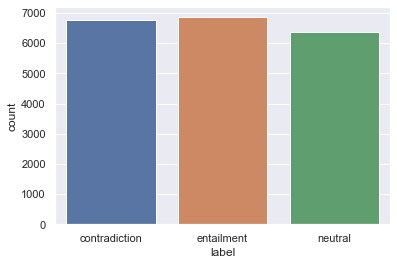

In [29]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

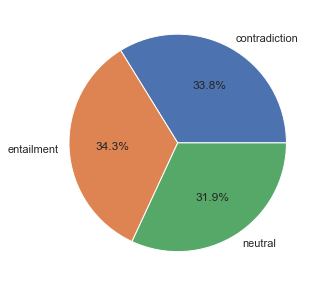

In [30]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3. Modeling

최종 목표인 Stacking Ensemble을 적용하기 위해서 개별 모델 3가지를 구현했습니다.  
각각 사전학습된 ELECTRA, BERT, ALBERT 모델에 대해 fine-tune을 적용했습니다.  
이전 electra 개별 모델 구현 파일에서 토크나이징 후 조정할 패딩의 길이를 100으로 정했습니다.  
따라서, 각각의 모델들의 input_layer의 shape을 (100,)으로 지정했습니다.  

### 3.1 개별 모델 구현 함수

In [31]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_BERT():
    with strategy.scope():
        encoder = TFBertModel.from_pretrained("kykim/bert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_ALBERT():
    with strategy.scope():
        encoder = TFAlbertModel.from_pretrained("kykim/albert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### 3.2 구현한 모델, 토크나이저 선언

In [32]:
model_bert = model_BERT()
model_albert = model_ALBERT()
model_electra = model_KoELECTRA()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
All model checkpoint layers were used when initializing TFAlbertModel.

All the layers of TFAlbertModel were initialized from the model checkpoint at kykim/albert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [33]:
tokenizer_bert = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
tokenizer_albert = BertTokenizerFast.from_pretrained("kykim/albert-kor-base")
tokenizer_electra = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

### 3.3 훈련 데이터 전처리

훈련데이터에 대해 각 문장에 대한 인코딩을 수행하고 패딩을 맞춰주는 전처리 작업을 진행합니다.  
훈련데이터를 7:3 비율로 훈련데이터와 검증데이터를 나눕니다.  
검증데이터는 각 개별 모델로 예측을 진행하고, 클래스에 대한 예측 확률 값들과 예측 클래스 값들을 통해 앙상블 데이터로 사용하게 됩니다.  
따라서, 최종 제출할 대상이 되는 테스트 데이터에 대해서도 예측을 하고 예측 확률 값들과 클래스를 저장하는 같은 과정을 거치게 됩니다.  

In [34]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

#### 3.3.1 ELECTRA 모델링

In [35]:
train_encoded_electra = tokenizer_electra.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_electra = tokenizer_electra.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_electra['input_ids']

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_electra['input_ids']

In [ ]:
# x_train, y_train = train_encoded_electra['input_ids'], train.label.values
# x_test = test_encoded_electra['input_ids']

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [ ]:
history_electra = model_electra.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                     validation_data=valid_dataset,epochs= 3)

In [ ]:
# history_electra = model_electra.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
#                                     epochs= 3)

In [ ]:
electra_pred = model_electra.predict(x_valid, verbose=1)
electra_pred_class = np.argmax(electra_pred, axis=1)

In [ ]:
test_pred_electra = model_electra.predict(test_dataset, verbose=1)
test_pred_electra_class = np.argmax(test_pred_electra, axis=1)

#### 3.3.2 BERT, ALBERT 모델링

In [ ]:
train_encoded_bert = tokenizer_bert.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_bert = tokenizer_bert.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_bert['input_ids'], train.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_bert['input_ids']

In [ ]:
# x_train, y_train = train_encoded_bert['input_ids'], train.label.values
# x_test = test_encoded_bert['input_ids']

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [ ]:
history_bert = model_bert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                              validation_data=valid_dataset, epochs= 3)

history_albert = model_albert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                  validation_data=valid_dataset, epochs= 3)

In [ ]:
bert_pred = model_bert.predict(x_valid, verbose=1)
albert_pred = model_albert.predict(x_valid)

In [ ]:
bert_pred_class = np.argmax(bert_pred, axis=1)
albert_pred_class = np.argmax(albert_pred, axis=1)

In [ ]:
test_pred_bert = model_bert.predict(test_dataset, verbose=1)
test_pred_albert = model_albert.predict(test_dataset, verbose=1)

test_pred_bert_class = np.argmax(test_pred_bert, axis=1)
test_pred_albert_class = np.argmax(test_pred_albert, axis=1)

In [ ]:
# print('bert 정확도: {0:.4f}'.format(accuracy_score(y_valid, bert_pred_class)))
# print('albert 정확도: {0:.4f}'.format(accuracy_score(y_valid, albert_pred_class)))

## 4. Stacking Ensemble learning

이전에 구했었던 검증 데이터에 대해 개별 모델로 예측한 메타데이터를 생성하여 스태킹 앙상블에 대한 훈련 데이터를 만들었습니다.  
또한, 최종 예측할 테스트 데이터에 대한 개별 모델 예측 메타데이터도 생성했습니다.  
만들어진 메타 데이터 학습을 하며 Stacking 앙상블을, 최종 판별 모델을 XGBoost를 사용하며 Boosting 앙상블을 적용했습니다.  
이렇게 만들어진 XGBoost 모델을 통해 테스트 메타 데이터에 똑같이 적용함으로써 최종 예측을 진행했습니다.  

### 4.1 메타 데이터 생성

In [ ]:
meta_data = np.array([
    np.transpose(electra_pred)[0], np.transpose(electra_pred)[1], np.transpose(electra_pred)[2], electra_pred_class,
    np.transpose(bert_pred)[0], np.transpose(bert_pred)[1], np.transpose(bert_pred)[2], bert_pred_class,
    np.transpose(albert_pred)[0], np.transpose(albert_pred)[1], np.transpose(albert_pred)[2], albert_pred_class
])
print(meta_data.shape)

In [ ]:
meta_data = np.transpose(meta_data)
print(meta_data.shape)

### 4.2 XGBoost Modeling

In [ ]:
from xgboost import XGBClassifier

xgb_final = XGBClassifier(silent=False,
                          n_estimators = 10000,
                          booster='gbtree',
                          tree_method='gpu_hist',
                          preidctor= 'gpu_predictor',
                          learning_rate=0.02,
                          objective='multi:softmax',
                          max_depth = 8,
                          subsample = 0.8,
                          random_state=42)

In [ ]:
final_model = xgb_final.fit(meta_data, y_valid)

In [ ]:
final = final_model.predict(meta_data)

In [ ]:
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_valid , final)))

In [ ]:
final

In [ ]:
len(final)

### 4.3 최종 예측 메타 데이터 생성 및 최종 판별 진행

In [ ]:
test_meta_data = np.array([
    np.transpose(test_pred_electra)[0], np.transpose(test_pred_electra)[1], np.transpose(test_pred_electra)[2], test_pred_electra_class,
    np.transpose(test_pred_bert)[0], np.transpose(test_pred_bert)[1], np.transpose(test_pred_bert)[2], test_pred_bert_class,
    np.transpose(test_pred_albert)[0], np.transpose(test_pred_albert)[1], np.transpose(test_pred_albert)[2], test_pred_albert_class
])
print(meta_data.shape)

In [ ]:
test_meta_data = np.transpose(test_meta_data)
print(meta_data.shape)

In [ ]:
predictions = final_model.predict(test_meta_data)

In [ ]:
predictions

In [ ]:
list1 = [i for i in range(5000)]

In [ ]:
list2 = predictions

In [ ]:
submission = pd.DataFrame({'index':list1,
                           'label':list2})

In [ ]:
submission

In [ ]:
# contradiction => 0 entailment => 1 neutral => 2
submission['label'].replace(0, 'contradiction', inplace=True)
submission['label'].replace(1, 'entailment', inplace=True)
submission['label'].replace(2, 'neutral', inplace=True)

## 5. versus Previous submission

리더보드에 올렸던 88%의 탐지율을 달성했던 csv파일과 유사도 비교를 진행했습니다.  
유사도가 90%이며, 성능이 어느 정도 올라갈 것이라는 판단을 할 수 있습니다.

In [ ]:
previous = pd.read_csv('../submission/submission_KoELECTRAv4.csv')

In [ ]:
previous['label']

In [ ]:
submission['label']

In [ ]:
cnt_equal = 0
cnt_diff = 0
for i in range(5000):
    if previous['label'][i] == submission['label'][i]:
        cnt_equal += 1
    else: cnt_diff += 1

similarity = cnt_equal/(cnt_equal+cnt_diff) * 100
print(f"이전 제출 파일과의 유사도:{similarity}%")

In [ ]:
submission.to_csv("../submission/submission_stacking_v1.csv", index = False)

In [ ]:
# model.save('competition_stacking_v1.h5')
# Load model code
# new_model = tf.keras.models.load_model('competition_stacking_v1.h5')
# test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)

In [ ]:
cnt_equal = 0
cnt_diff = 0
arr = []
for i in range(5000):
    if previous['label'][i] == submission['label'][i]:
        cnt_equal += 1
    else:
        cnt_diff += 1
        arr.append(i)

similarity = cnt_equal/(cnt_equal+cnt_diff) * 100
print(f"이전 제출 파일과의 유사도:{similarity}%")

In [ ]:
arr

In [ ]:
arr[100:]

In [ ]:
pd.DataFrame({"index":arr,
             ""})

In [ ]:
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence

In [ ]:
task = "nli"
datasets = load_dataset("klue", task)

In [ ]:
datasets["train"][0]

In [ ]:
arr_train_premise = datasets["train"]["premise"]

In [ ]:
arr_train_hypothesis = datasets["train"]["hypothesis"]

In [ ]:
arr_train_label = datasets["train"]["label"]

In [ ]:
len(arr_train_hypothesis)

In [ ]:
len(arr_train_hypothesis)

In [ ]:
len(arr_train_label)

In [ ]:
arr2 = datasets[""]

In [ ]:
pd.DataFrame({"prmise":arr}).to_csv("../submission/klue_train.csv", index = False)